In [5]:
""" Machine Learning on Data Without Preliminary Cleaning """

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import mdshare
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

def matplotlib_imshow(img):
    """ using plt to plot img in tensorboard """
    img = img.mean(dim=0)
    npimg = img.cpu().detach().numpy()
    plt.imshow(npimg, cmap="Greys")

In [18]:
# Data load
DATA = mdshare.fetch("alanine-dipeptide-3x250ns-heavy-atom-distances.npz")
with np.load(DATA) as f:
    dataset = np.vstack([f[key] for key in sorted(f.keys())])
    
dataset -= dataset.min()
dataset /= dataset.max()

x_train, x_test = train_test_split(dataset, train_size=0.7)

BATCH_SIZE = 1000
BATCH_PART = 20
EPOCHS = 15

# Data loader for easy mini-batch return in training
train_loader = Data.DataLoader(
    dataset=x_train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = Data.DataLoader(
    dataset=x_test,
    batch_size=BATCH_SIZE,
    shuffle=True
)

class AutoEncoder(nn.Module):
    """ autoencoder class
        for now only holds:
            X variable
            y variable
    """

    # def __init__(self, x, y=None):
    def __init__(self):
        """
        initializing autoencoder class
        """
        super(AutoEncoder, self).__init__()

        # self.X = torch.from_numpy(x).type(torch.FloatTensor)
        # self.y = y

        self.input_layer = nn.Linear(45, 20)
        self.encode_1 = nn.Linear(20, 10)
        self.encode_2 = nn.Linear(10, 5)
        self.encode_3 = nn.Linear(5, 2)

        self.decode_1 = nn.Linear(2, 5)
        self.decode_2 = nn.Linear(5, 10)
        self.decode_3 = nn.Linear(10, 20)
        self.output_layer = nn.Linear(20, 45)

        self.input = None

    def forward(self, x):
        """
        initialize forward method
        """
        x = self.encode(x)
        x = self.decode(x)

        return x

    def print(self):
        """ prints variables """
        print("X:", self.X, "\ny:", self.y)

    def encode(self, x):
        """
        encoding function
        """

        x = F.tanh(self.input_layer(x))
        x = F.tanh(self.encode_1(x))
        x = F.tanh(self.encode_2(x))

        return F.tanh(self.encode_3(x))

    def decode(self, z):
        """
        decoding function
        """

        z = F.tanh(self.decode_1(z))
        z = F.tanh(self.decode_2(z))
        z = F.tanh(self.decode_3(z))

        return F.tanh(self.output_layer(z))

    def trainIters(self, mod, optim):
        """
        training iterations method
        """
        def train_step(x):
            mod.train()
            predict = mod(x)

            optim.zero_grad()

            los = self.lossfunction()
            los = los(self.input, predict)

            los.backward()

            optim.step()

            return los.item()

        return train_step

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = torch.nn.MSELoss()

# train = model.trainIters(model, optimizer)
losses = []

# Set model into train mode
model.train()

# train
for epoch in range(EPOCHS):
    batch_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
        # print(f'Epoch: {epoch} batch_idx: {batch_idx}')
        data = data.to(device)
        output = model(data)
        loss = criterion(output, data)
        batch_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch: {}\t'.format(epoch + 1) \
        + 'avg loss: {:.5f}\t'.format(batch_loss / 525) \
        + 'loss: {:.5f}\t'.format(batch_loss))


# Set model into evaluation mode
model.eval()

/Users/jr/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch: 1	avg loss: 0.00969	loss: 5.08552	
epoch: 2	avg loss: 0.00168	loss: 0.88244	
epoch: 3	avg loss: 0.00101	loss: 0.52945	
epoch: 4	avg loss: 0.00091	loss: 0.47853	
epoch: 5	avg loss: 0.00090	loss: 0.47102	
epoch: 6	avg loss: 0.00089	loss: 0.46804	
epoch: 7	avg loss: 0.00089	loss: 0.46512	
epoch: 8	avg loss: 0.00086	loss: 0.45235	
epoch: 9	avg loss: 0.00068	loss: 0.35910	
epoch: 10	avg loss: 0.00046	loss: 0.24161	
epoch: 11	avg loss: 0.00042	loss: 0.22085	
epoch: 12	avg loss: 0.00041	loss: 0.21757	
epoch: 13	avg loss: 0.00041	loss: 0.21621	
epoch: 14	avg loss: 0.00041	loss: 0.21520	
epoch: 15	avg loss: 0.00041	loss: 0.21481	


AutoEncoder(
  (input_layer): Linear(in_features=45, out_features=20, bias=True)
  (encode_1): Linear(in_features=20, out_features=10, bias=True)
  (encode_2): Linear(in_features=10, out_features=5, bias=True)
  (encode_3): Linear(in_features=5, out_features=2, bias=True)
  (decode_1): Linear(in_features=2, out_features=5, bias=True)
  (decode_2): Linear(in_features=5, out_features=10, bias=True)
  (decode_3): Linear(in_features=10, out_features=20, bias=True)
  (output_layer): Linear(in_features=20, out_features=45, bias=True)
)

In [40]:
embd = np.zeros(shape=(525, 1000, 2))
for batch_idx, data in enumerate(train_loader):
    mapping = model.encode(data).detach()
    embd[batch_idx] = mapping

In [41]:
embd_c = np.concatenate(embd, axis=0)

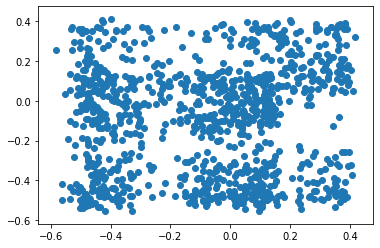

In [42]:
plt.scatter(embd[:, 0], embd[:, 1])